In [1]:
#Imports
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, generate_preset_pass_manager, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

In [1]:
service = QiskitRuntimeService(name="XYZ")
service.saved_accounts()

NameError: name 'QiskitRuntimeService' is not defined

In [3]:
#Creating the database
items = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
    'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
    'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
    'Y', 'Z', 'A1', 'B1', 'C1', 'D1', 'E1', 'F1'
]

n = 5

In [7]:
#Defining the target items
targets = ['A', 'R', 'D1']

#Converting to binary indices
target_idx = [items.index(t) for t in targets]
target_keys = [format(idx, "05b") for idx in target_idx]
print("The target items are:")
for t, k in zip(targets, target_keys):
    print(f"  {t} → |{k}⟩")
print()

The target items are:
  A → |00000⟩
  R → |10001⟩
  D1 → |11101⟩



In [46]:
#Initializing the quantum circuit
qr = QuantumRegister(n, name='q')
cr = ClassicalRegister(n, name='c')
qc = QuantumCircuit(qr, cr, name='Grover searching')

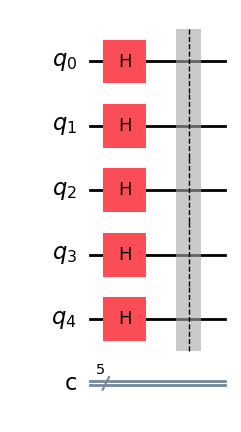

In [47]:
#Initializing states in superposition
qc.h(qr)
qc.barrier()
qc.draw('mpl')

In [48]:
oracle = QuantumCircuit(n, name='Oracle')

for key in target_keys:
    for i, bit in enumerate(key):
        if bit == '0':
            oracle.x(i)
    oracle.h(n - 1)
    oracle.mcx(list(range(n - 1)), n - 1)  # multi-controlled Z
    oracle.h(n - 1)
    for i, bit in enumerate(key):
        if bit == '0':
            oracle.x(i)
    oracle.barrier()


In [49]:
diffuser = QuantumCircuit(n, name='Diffuser')
diffuser.h(range(n))
diffuser.x(range(n))
diffuser.h(n - 1)
diffuser.mcx(list(range(n - 1)), n - 1)
diffuser.h(n - 1)
diffuser.x(range(n))
diffuser.h(range(n))
diffuser.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(<Qubit register=(5, "q"), index=0>, <Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=2>, <Qubit register=(5, "q"), index=3>, <Qubit register=(5, "q"), index=4>), clbits=())

In [50]:
#Circuit appends
qc.append(oracle.to_instruction(), qr)
qc.barrier()

qc.append(diffuser.to_instruction(), qr)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(<Qubit register=(5, "q"), index=0>, <Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=2>, <Qubit register=(5, "q"), index=3>, <Qubit register=(5, "q"), index=4>), clbits=())

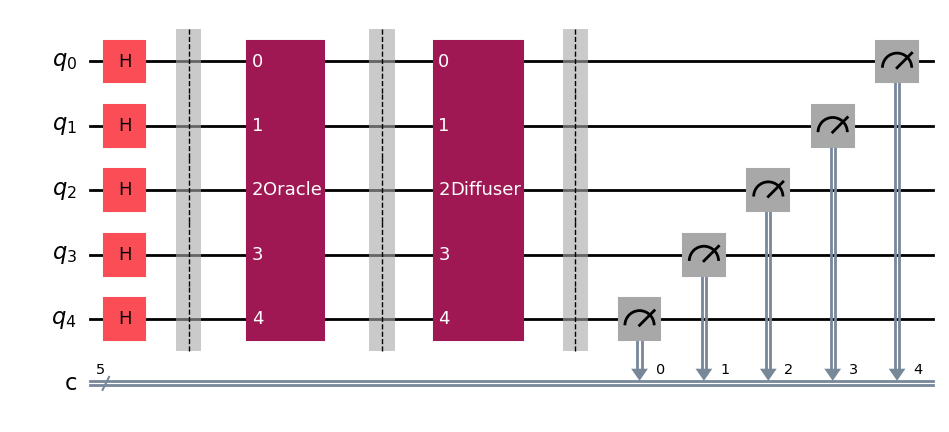

In [51]:
#Measurement
qc.measure(qr[::-1], cr)
qc.draw("mpl")

In [55]:
#Backend selection for circuit run
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-10-15 17:05:40,545: Default instance not set. Searching all available instances.


ibm_torino


In [56]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
sampler = Sampler(mode=backend)

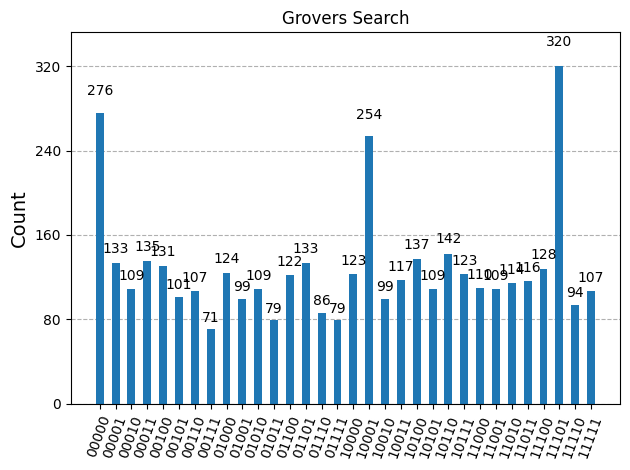

In [59]:
#Running the circuit on backend and plot vizualization
job = sampler.run(pm.run([qc]))
results = job.result()
counts = results[0].data.c.get_counts()
plot_histogram(counts, title="Grovers Search")

In [54]:
#Results
top_states = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]
for state, count in top_states:
    idx = int(state, 2)
    print(f"  |{state}⟩ → {items[idx]}  ({count} counts)")

print("\n Target items were:", targets)

  |00000⟩ → A  (443 counts)
  |10001⟩ → R  (439 counts)
  |11101⟩ → D1  (428 counts)
  |00110⟩ → G  (33 counts)
  |01111⟩ → P  (32 counts)

 Target items were: ['A', 'R', 'D1']
